# Pythonradex
Re-implementation of the RADEX code.
Adventages of pythonradex:
- faster
- provides a convenient method to read files from the LAMDA database, official website: https://home.strw.leidenuniv.nl/~moldata/.
- provides additional functionality that is not included in RADEX (treatment of overlapping lines)
- RADEX calculates the flux for all geometries using the equation which is only valid for slab geometry, pythonradex uses the correct formulae for spherical geometries.



In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(dir(pythonradex))

['LAMDA_file', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'atomic_transition', 'escape_probability', 'escape_probability_functions', 'flux', 'helpers', 'molecule', 'radiative_transfer', 'rate_equations']


# Getting started with pythonradex

- Radiative transfer calculation is conducted using the Cloud class which is provided by the radiative_transfer module
- Possible geometries: "Gaussian",  “rectangular”, "LVG sphere", "LVG slab”
- For LVG geometries the parameter "line_profile_type" needs to be set to “rectangular”. This ensures that the optical depth is calculated correctly.


In [3]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot = 1e16 / constants.centi**2  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## line width parameter "width_v" explained
- There are different interpretations of the input parameter width_v used by pythonradex
-  For static geometries, this refers to the local emission width, two kinds of local emission profiles:

  - "Gaussian" in which case width_v refers to the FWHM
  - "rectangular" in which case width_v refers to the FWHM
- For the LVG geometries (“LVG sphere” and “LVG slab”), width_v refers to the global velocity width of the cloud

## Set the parameters characterising the cloud physical conditions.
- use update_parameters method to do this.


In [4]:
## possible atributes of the cloud object
# update_parameters
# solve_radiative_transfer()
# fluxes_of_individual_transitions(solid_angle, transitions)

In [5]:
N = 1e16 / constants.centi**2  # CO column density in m-2
Tkin = 120  # kinetic temperature in [K]
# collider densities in m-3:
collider_densities_LTE = {
    "para-H2": 1e6 / constants.centi**3,
    "ortho-H2": 3e6 / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

In [6]:
# print the results
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202     120.76      0.0232358      0.0665861     0.00739182
   2    1     230.538000     120.46      0.0665861       0.101238      0.0276572
   3    2     345.795990     120.07       0.101238       0.123436      0.0556417
   4    3     461.040768     119.59       0.123436       0.131896      0.0843874
   5    4     576.267931     119.03       0.131896       0.127783       0.107386
   6    5     691.473076     118.38       0.127783       0.114098       0.120167
   7    6     806.651806     117.64       0.114098      0.0947338       0.121205
   8    7     921.799700     116.77      0.0947338      0.0735066       0.111756
   9    8    1036.912393     115.81      0.0735066       0.053459       0.095006
  10    9    1151.985452     114.66       0.053459      0.0364828      0.0749019
  11   10    1267.014486     113.53      0.0364828      0.0233878      0.0549295
  12   11    1381.995105   

‘poplow’ and ‘popup’ gives the fracitional populations of the lower and upper level respectively, and ‘tau_nu0’ the optical depth at the line centre.

## How fractional population is defined:

Column density of the lower state $N_u$
Fractional population of the lower level  $n_u$ is the proportion of particles in the lower state relative to the total population of the species ($N_{tot}$):
$$n_u = \frac{N_u}{N_{tot}}$$

In [ ]:
def extract_values(cloud_name, data_of_molecule):
    """Extract values from the cloud object and the data file.

    Prameters:
    ----------
    cloud_name : pythonradex.radiative_transfer.Cloud
        The cloud object that contains the radiative transfer solution.
    data_of_molecule : dict
        The data file of the molecule.

    Returns:
    Tex: np.array
        The excitation temperature of the molecule.
    tau: np.array
        The optical depth of the transitions.
    Aul : np.array
        The Einstein coefficient for spontaneous emission.
    Bul : np.array
        The Einstein coefficient for stimulated emission.
    nu0_array : np.array
        The frequency of the transition in Hz.
    Eu : np.array
        The energy of the upper level in Kelvin.
    """

    # Excitation temperature
    Tex = cloud_name.Tex

    # Optical depth (tau_nu0) of the transitions
    tau = cloud_name.tau_nu0_individual_transitions

    # get Aul, Bul
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21

    # get the frequency of the transition in Hz
    nu0_array = cloud_name.emitting_molecule.nu0

    # extract atributtes from the data file
    levels = data_of_molecule["levels"]
    rad_transitions = data_of_molecule["radiative transitions"]
    coll_transitions = data_of_molecule["collisional transitions"]
    quantum_numbers = data_of_molecule["quantum numbers"]

    # This line extracts the "E" attribute from each object in levels and converts it to a NumPy array
    # and convert energies from jouls to kelvin
    Eu = np.array([level.E for level in levels]) / constants.k
    # alternative way to extract upper energy level, extracted from the radiative transitions
    # Eu_test = np.array([trans.up.E for trans in rad_transitions]) / constants.k

    # remove first component, sinze the first is nan
    Eu = Eu[1:]

    # get the statistical weight of the upper level
    g_weigth = np.array([level.g for level in levels])
    g_weigth = g_weigth[1:]
    # testing
    # print("Are the the two methods the same?", np.allclose(Eu, Eu_test))

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth


# Read file from the LAMDA database

In [8]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)
# LAMDA_file returns a dictionary containing the data read from the file.

# Full list of attributes
print(data_co.keys())

dict_keys(['levels', 'radiative transitions', 'collisional transitions', 'quantum numbers'])


In [ ]:
# get the values from the cloud object
TexCo, tauCo, AulCo, BulCo, nu0_arrayCo, EuCo, gCO = extract_values(cloud, data_co)

# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

fluxCo = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)


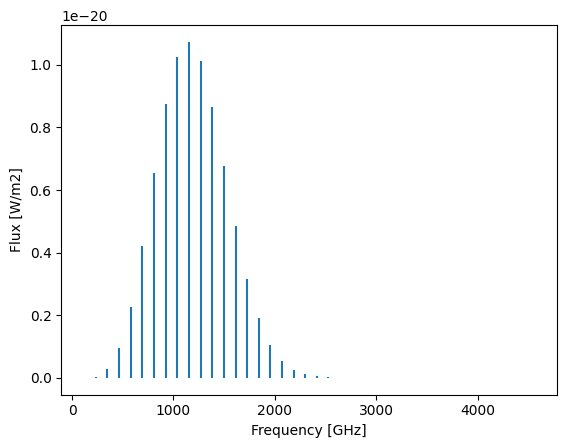

In [10]:
# plot the spectrum with individual fluxes
plt.stem(nu0_arrayCo / constants.giga, fluxCo, basefmt=" ", markerfmt=" ")

# to plot as a gaussina curve
# plt.plot(array_nu0 / constants.giga, flux, drawstyle="steps-mid")

plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux [W/m2]")
plt.show()

In [11]:
def gamma_tau_calculator(cloud_name, colum_density_species, Aul_coeff, Bul_coeff, nu0):
    """Calculates the gamma factor for radiative transitions and the optical depth

    Parameter:
    ----------
    cloud_name:
        Cloud object
    colum_density_species:
        total column density of the species in m^-2
    Aul_coeff:
        Einstein A coefficient for the transition
    Bul_coeff:
        Einstein B coefficient for the transition
    nu0:
        frequency of the transition

    Returns:
    --------
    gamma:
        gamma factors
    tau:
        optical depths
    tau_manual:
        numpy array of optical depths calculated manually

    """
    # get the optical depth
    tau = cloud_name.tau_nu(nu0)

    # compute upper level population density, given by: fractional population density x total column density
    # cloud.level_pop gives the fractional population density of lowest level (len 41), by removing the first element we get the fractional population density of the upper levels
    Nu = cloud.level_pop[1:] * colum_density_species

    # calculate tau manually
    tau_manual = ((constants.h * Nu * Bul_coeff) / (width_v)) * (np.exp((constants.h * nu0) / (constants.k * Tkin)) - 1)

    # calculate the gamma factor
    gamma = 8 * np.pi * constants.k * nu0**2 / (constants.h * constants.c**3 * Aul_coeff)

    # print for testing
    print("Are the the two methods for computing tau the same?", np.allclose(tau, tau_manual))

    return gamma, tau, tau_manual

Are the the two methods for computing tau the same? False


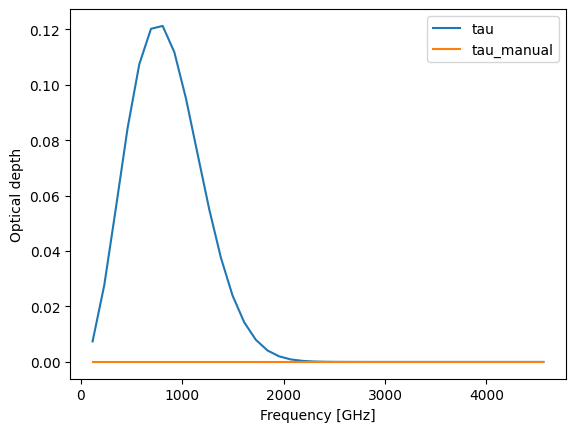

In [ ]:
# compute the gamma factor for radiative transitions
gamma_factor, tau_co, tau_co_manual = gamma_tau_calculator(cloud, N, AulCo, BulCo, nu0_arrayCo)

# plot the optical depth
plt.plot(nu0_arrayCo / constants.giga, tau_co, label="tau")
plt.plot(nu0_arrayCo / constants.giga, tau_co_manual, label="tau_manual")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Optical depth")
plt.legend()
plt.show()

# get the y axis of the plot: ln(γ_u * W / g_u)
y_values = np.log(gamma_factor * fluxCo / gCO)

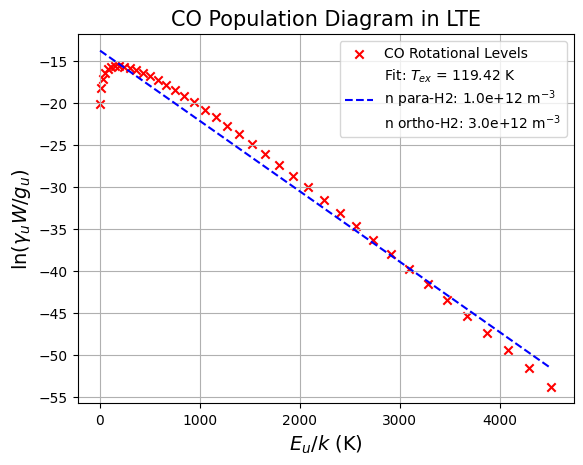

In [13]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values, marker="x", color="red", label="CO Rotational Levels")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {collider_densities_LTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_LTE['ortho-H2']:.1e} m$^{{-3}}$"),
)
plt.legend()
ax.grid()
plt.show()

In [14]:
print(f"Excitation temperature: {T_ex:.5g} K")
print(f"kinetic temperature of the nebula: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 119.42 K
kinetic temperature of the nebula: 120 K


As expected in LTE:
$$T_{ex} = T_{kin}$$

However the y axis have the wrong sign

## Consider the escape propability SKIP THIS SECTION IS FOR TESTING
Escape probability for a homogeneous, static sphere is given by:

 
$$
\beta(\tau_\nu) = \frac{3}{2\tau_\nu} \left( 1 - \frac{2}{\tau_\nu^2} + \left( \frac{2}{\tau_\nu} + \frac{2}{\tau_\nu^2} \right) e^{-\tau_\nu} \right)
$$

$\tau_\nu$ is the optical depth.

Equation for the population diagram taking into acount optical depth is: 
$$
ln{\frac{\gamma_u W}{g_u \beta}}=ln{N/Z}-\frac{E_u}{kT}
$$

In [15]:
def beta_tau_test(tau_nu):
    """Calculate the escape probability for homogeneous, static sphere"""
    if tau_nu.any() == 0:
        return np.inf  # Avoid division by zero
    return (3 / (2 * tau_nu)) * (1 - (2 / tau_nu**2) + ((2 / tau_nu) + (2 / tau_nu**2)) * np.exp(-tau_nu))


In [16]:
# get optical depth
tauCo = cloud.tau_nu(nu=nu0_arrayCo)
tauCo

array([7.39182318e-03, 2.76572026e-02, 5.56416588e-02, 8.43873698e-02,
       1.07386132e-01, 1.20167069e-01, 1.21204523e-01, 1.11756237e-01,
       9.50059519e-02, 7.49019437e-02, 5.49294931e-02, 3.75006571e-02,
       2.38855203e-02, 1.42655637e-02, 7.95602796e-03, 4.12514667e-03,
       2.00302903e-03, 9.07099841e-04, 3.83258461e-04, 1.51447260e-04,
       5.58208613e-05, 1.91782738e-05, 6.15459607e-06, 1.84644706e-06,
       5.21167839e-07, 1.37969707e-07, 3.41092052e-08, 7.85902676e-09,
       1.68859308e-09, 3.44017469e-10, 6.63900380e-11, 1.19970789e-11,
       2.04373799e-12, 3.26200419e-13, 4.96189496e-14, 7.12389124e-15,
       9.69429634e-16, 1.24124857e-16, 1.49213986e-17, 1.72720078e-18])

In [17]:
# # plot population diagram
# fig, ax = plt.subplots()
# plt.scatter(Eu_co, y_values, marker="x", color="red", label="CO Rotational Levels")
# plt.scatter(Eu_co, y_values_corrected, marker="x", color="blue", label="CO Rotational Levels with optical depth correction")
# plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
# plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
# plt.title("CO Population Diagram in LTE", fontsize=15)

# # # Fit a straight line to estimate T_ex
# fit = np.polyfit(Eu_co, y_values, 1)  # Linear fit
# T_ex = -1 / fit[0]  # Rotational temperature from slope

# # Plot the best-fit line
# x_fit = np.linspace(min(Eu_co), max(Eu_co), 100)
# y_fit = fit[0] * x_fit + fit[1]
# plt.plot(
#     x_fit,
#     y_fit,
#     linestyle="--",
#     color="blue",
#     label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {collider_densities_LTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_LTE['ortho-H2']:.1e} m$^{{-3}}$"),
# )
# plt.legend()
# ax.grid()
# plt.show()

# Line profile of CO


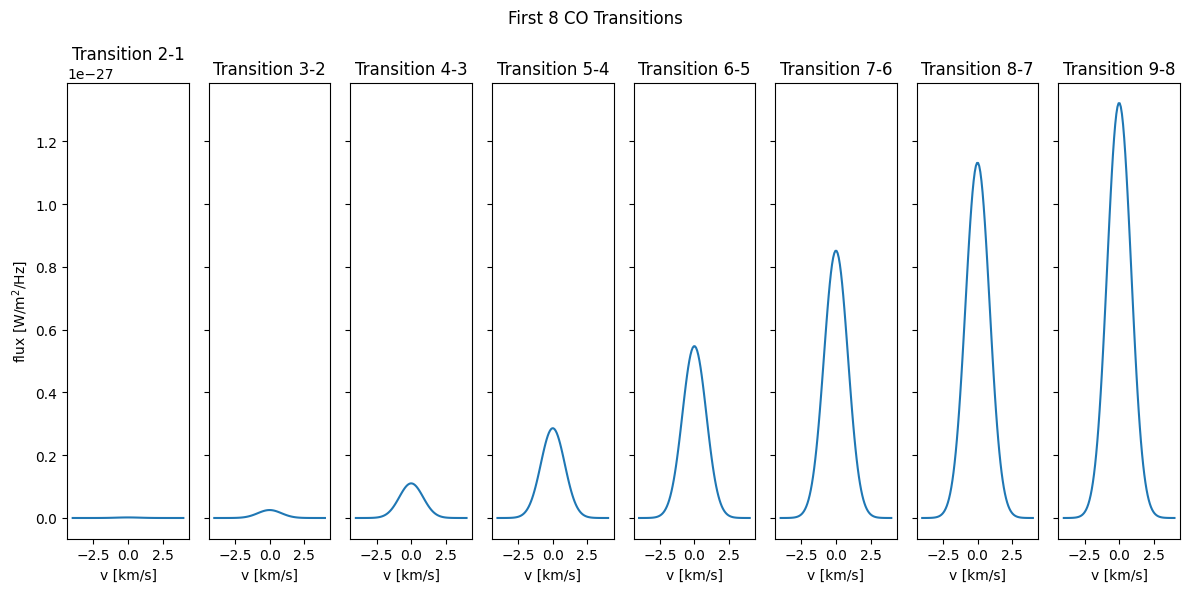

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = cloud.emitting_molecule.nu0[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# Plot CO population diagram for non-LTE case

In [19]:
# update the clud using low densities of h2
collider_densities_nonLTE = {
    "para-H2": 2e2 / constants.centi**3,
    "ortho-H2": 6e2 / constants.centi**3,
}

N = 1e16 / constants.centi**2  # CO column density in m-2
Tkin = 120  # kinetic temperature in [K]
# collider densities in m-3:

cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_nonLTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

cloud.solve_radiative_transfer()

In [20]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      56.23       0.166985       0.454013       0.111165
   2    1     230.538000      11.20       0.454013       0.281867        1.34847
   3    2     345.795990      10.12       0.281867      0.0765565       0.967217
   4    3     461.040768      11.97      0.0765565      0.0155116       0.261017
   5    4     576.267931      16.86      0.0155116     0.00367598      0.0491021
   6    5     691.473076      22.56     0.00367598    0.000997868      0.0108925
   7    6     806.651806      27.43    0.000997868    0.000280757     0.00285835
   8    7     921.799700      32.18    0.000280757     8.0462e-05    0.000784673
   9    8    1036.912393      36.21     8.0462e-05    2.27524e-05    0.000222408
  10    9    1151.985452      40.16    2.27524e-05    6.34715e-06    6.22991e-05
  11   10    1267.014486      44.12    6.34715e-06    1.75215e-06    1.72368e-05
  12   11    1381.995105   

In [21]:
# calculate the observed fluxes [W/m2], outputed as a list
flux_nonLTE = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle_co)

# convert flux to np.array
flux_nonLTE = np.array(flux_nonLTE)

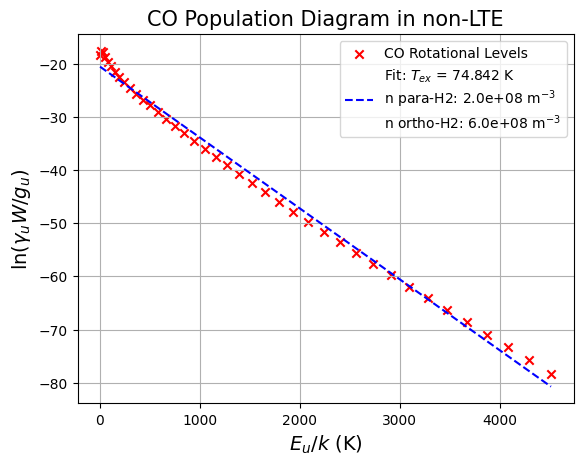

In [22]:
# get the new non-lte y values: ln(γ_u * W / g_u)
y_values_nonLTE = np.log(gamma_factor * flux_nonLTE / gCO)

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values_nonLTE, marker="x", color="red", label="CO Rotational Levels")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in non-LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values_nonLTE, 1)  # Linear fit
T_ex_nonLTE = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(f"Fit: $T_{{ex}}$ = {T_ex_nonLTE:.5g} K\nn para-H2: {collider_densities_nonLTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_nonLTE['ortho-H2']:.1e} m$^{{-3}}$"),
)
plt.legend()
ax.grid()
plt.show()

In [23]:
print(f"Excitation temperature: {T_ex_nonLTE:.5g} K")
print(f"Kinetic temperature of the cloud: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 74.842 K
Kinetic temperature of the cloud: 120 K


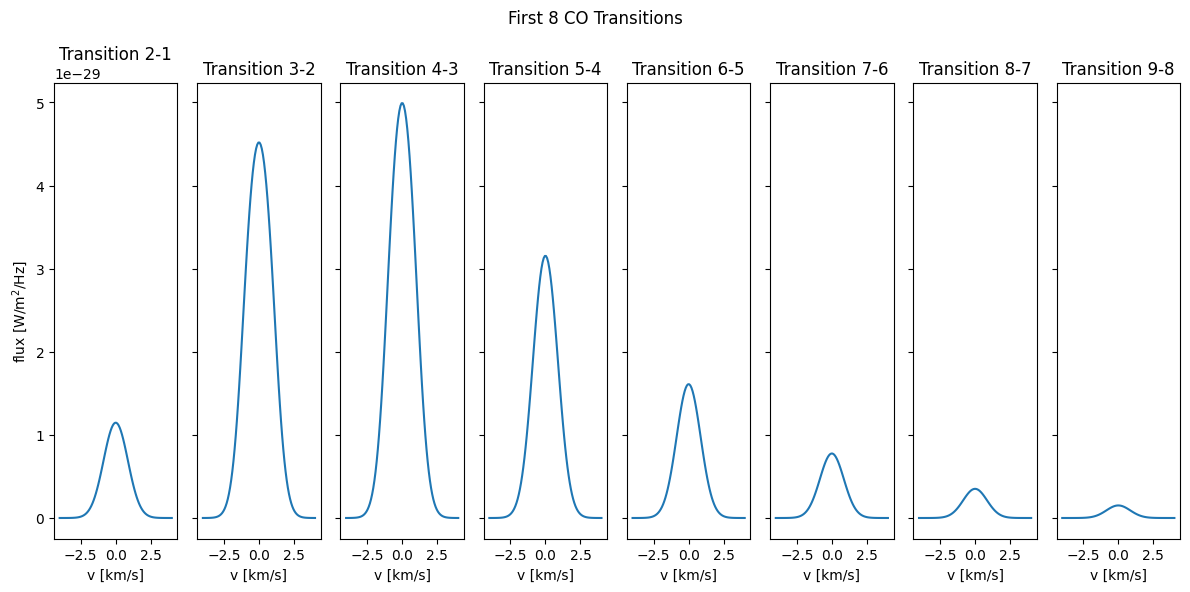

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = cloud.emitting_molecule.nu0[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]  # Select subplot in 2x4 grid
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# Plot population diagram for CH3OH-e

In [37]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CH3OH from LAMBDA database
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"  # file downloaded from LAMDA database

# store the data
data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot_emeth = 1e16 / constants.centi**2  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "rectangular" or "Gaussian"
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e16 / constants.centi**2  # CH3OH_e column density in m-2
Tkin = 120  # kinetic temperature in [K]

# collider densities in m-3, for ch3oh-e ther is only one input parameter, hence no distinction between para- an otho-H2
LTE_collider_densities_h2only = {"H2": 1e7 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer, i.e. calculate the level population with an iterative method
cloud_metahnol.solve_radiative_transfer()

79-78: tau_nu0 = -0.733
46-45: tau_nu0 = -1.58
28-27: tau_nu0 = -0.000154
26-24: tau_nu0 = -7.66e-06
91-89: tau_nu0 = -0.00106
13-12: tau_nu0 = -1.79
18-17: tau_nu0 = -2.26
10-8: tau_nu0 = -1.05
23-22: tau_nu0 = -2.54
30-27: tau_nu0 = -2.67
37-36: tau_nu0 = -2.66
44-43: tau_nu0 = -2.45
54-53: tau_nu0 = -2.17
65-64: tau_nu0 = -1.91
49-48: tau_nu0 = -4.51e-12
79-77: tau_nu0 = -1.58
92-91: tau_nu0 = -1.32
105-104: tau_nu0 = -0.974
121-120: tau_nu0 = -0.788
14-12: tau_nu0 = -0.193
68-66: tau_nu0 = -0.000204
9-7: tau_nu0 = -2.46
38-37: tau_nu0 = -0.0011
86-85: tau_nu0 = -0.00307
10-7: tau_nu0 = -4.01e-06
92-89: tau_nu0 = -0.638
59-56: tau_nu0 = -1.47
38-36: tau_nu0 = -0.00021
13-11: tau_nu0 = -6.92e-08
33-31: tau_nu0 = -1.27e-05
104-103: tau_nu0 = -0.000955
58-55: tau_nu0 = -1.67e-11
19-17: tau_nu0 = -0.219
137-136: tau_nu0 = -9.31e-06
80-78: tau_nu0 = -0.000372
16-14: tau_nu0 = -2.68
46-44: tau_nu0 = -0.00198
105-103: tau_nu0 = -0.496
15-12: tau_nu0 = -6.63e-05
20-17: tau_nu0 = -0.000222
1

In [38]:
# extract_values
TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

In [42]:
nu0_arrayCH3OH

array([2.93796609e+09, 3.38765478e+09, 7.28495673e+09, ...,
       5.92386899e+12, 5.95372832e+12, 5.99351078e+12])

In [39]:
cloud_metahnol.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
  79   78       2.937966      -0.10     0.00303219       0.012831      -0.733133
  14   13       3.387655       0.34      0.0155403      0.0123278    1.57909e-05
  96   95       7.284957       4.36      0.0010067     0.00101755      0.0051741
  30   28       9.413483       1.34      0.0333851      0.0206504    0.000552892
  46   45       9.923130      -0.51      0.0107312       0.030361       -1.57949
   5    4      12.171574       0.75      0.0237705     0.00779342        2.14117
 132  131      14.899685       0.61     0.00251749    0.000728891     0.00210954
  28   27      15.619187      -0.77       0.010987      0.0333851    -0.00015352
  58   56      18.347298       1.32     0.00956237     0.00438718    9.84415e-05
   8    7      19.966178       4.76      0.0103254     0.00603028       0.145795
  42   40      22.304559       1.65     0.00518591     0.00229731    8.98284e-13
  78   77      23.383812   

In [58]:
# compute flux for the first 10 transitions

# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

frequancy_test = np.arange(1, 20, 0.005) * constants.giga

# spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=nu0_arrayCH3OH[:10])

spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=frequancy_test)

In [59]:
spectrum_methanol

array([0., 0., 0., ..., 0., 0., 0.])

C:\Users\alios\AppData\Local\Temp\ipykernel_14216\358637.py:3: RuntimeWarning: divide by zero encountered in log
  ax.stem(frequancy_test / constants.giga, -np.log(spectrum_methanol), basefmt=" ", markerfmt=" ")


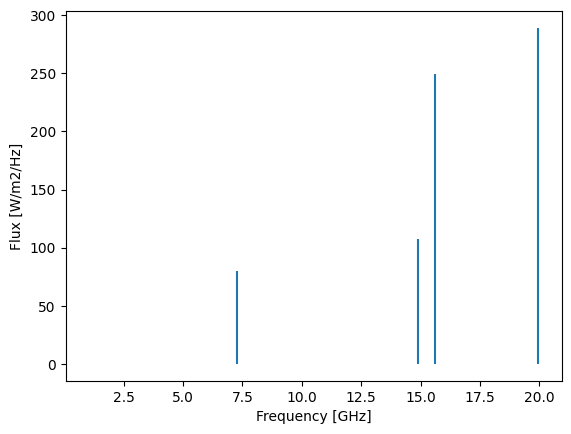

In [ ]:
# plot the spectrum with individual fluxes
fig, ax = plt.subplots()
ax.stem(frequancy_test / constants.giga, -np.log(spectrum_methanol), basefmt=" ", markerfmt=" ")
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Flux [W/m2/Hz]")
plt.show()

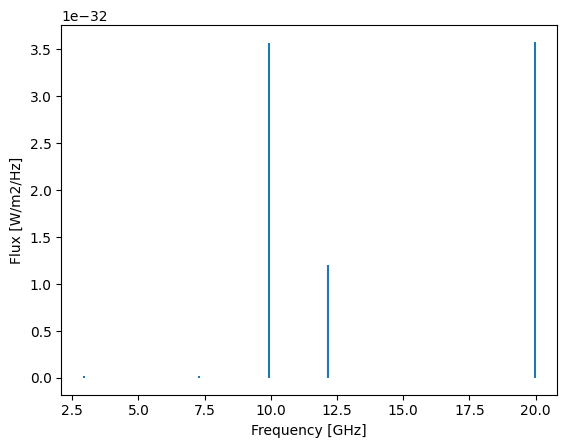

In [46]:
# plot the spectrum with individual fluxes
fig, ax = plt.subplots()
ax.stem(nu0_arrayCH3OH[:10] / constants.giga, spectrum_methanol, basefmt=" ", markerfmt=" ")
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Flux [W/m2/Hz]")
plt.show()
